In [43]:
import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Configuration
DATA_PATH = Path("F:/Brain_Tumour/Brain_Tumor_Classification/data/raw")
PROCESSED_PATH = Path("F:/Brain_Tumour/Brain_Tumor_Classification/data/processed")
CLASSES = ["no_tumor", "yes_tumor"]  # 0=healthy, 1=tumor
TARGET_SIZE = (256, 256)
SEED = 42

# Create processed directories
(PROCESSED_PATH/"train").mkdir(parents=True, exist_ok=True)
(PROCESSED_PATH/"val").mkdir(parents=True, exist_ok=True)
(PROCESSED_PATH/"test").mkdir(parents=True, exist_ok=True)


In [45]:
def load_image_paths():
    """Returns (image_paths, labels) with balanced classes"""
    image_paths, labels = [], []
    
    for class_idx, class_name in enumerate(CLASSES):
        class_dir = DATA_PATH/class_name
        paths = sorted(list(class_dir.glob("*")))  # Sort for reproducibility
        image_paths.extend(paths)
        labels.extend([class_idx] * len(paths))
        
    return image_paths, labels

# Load all data
all_paths, all_labels = load_image_paths()
print(f"Total images: {len(all_paths)} (Healthy: {all_labels.count(0)}, Tumor: {all_labels.count(1)})")

Total images: 195 (Healthy: 65, Tumor: 130)


In [47]:
print(f"Raw data exists: {DATA_PATH.exists()}")
print(f"Subdirectories: {[d.name for d in DATA_PATH.iterdir() if d.is_dir()]}")

Raw data exists: True
Subdirectories: ['no_tumor', 'yes_tumor']


In [49]:
# Count images per class
for class_name in CLASSES:
    class_dir = DATA_PATH/class_name
    print(f"{class_name}: {len(list(class_dir.glob('*')))} images")

no_tumor: 65 images
yes_tumor: 130 images


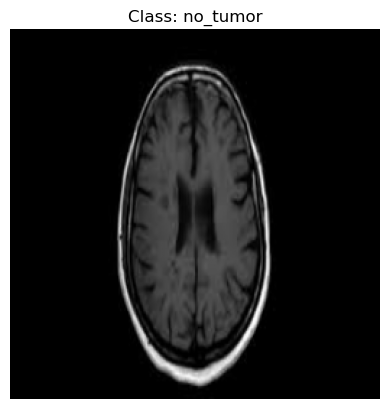

In [51]:
def preprocess_image(img_path):
    """
    Standard preprocessing:
    1. Read image
    2. Convert to RGB
    3. Resize
    4. Normalize to [0,1]
    """
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default
    img = cv2.resize(img, TARGET_SIZE)
    return img / 255.0  # Normalize

# Test on a sample
sample = preprocess_image(all_paths[0])
plt.imshow(sample)
plt.title(f"Class: {CLASSES[all_labels[0]]}")
plt.axis('off')
plt.show()

In [53]:
# Stratified split (maintains class ratios)
X_train, X_temp, y_train, y_temp = train_test_split(
    all_paths, all_labels,
    test_size=0.3,
    stratify=all_labels,
    random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=SEED
)

print(f"Train: {len(X_train)} (Healthy: {y_train.count(0)}, Tumor: {y_train.count(1)})")
print(f"Val: {len(X_val)} (Healthy: {y_val.count(0)}, Tumor: {y_val.count(1)})")
print(f"Test: {len(X_test)} (Healthy: {y_test.count(0)}, Tumor: {y_test.count(1)})")

Train: 136 (Healthy: 45, Tumor: 91)
Val: 29 (Healthy: 10, Tumor: 19)
Test: 30 (Healthy: 10, Tumor: 20)


In [55]:
def save_processed_data(paths, labels, subset):
    """Save images and labels as numpy arrays"""
    images = np.array([preprocess_image(p) for p in paths])
    labels = np.array(labels)
    
    np.save(PROCESSED_PATH/subset/"images.npy", images)
    np.save(PROCESSED_PATH/subset/"labels.npy", labels)
    print(f"Saved {len(images)} {subset} samples")

# Execute for all splits
save_processed_data(X_train, y_train, "train")
save_processed_data(X_val, y_val, "val")
save_processed_data(X_test, y_test, "test")

Saved 136 train samples
Saved 29 val samples
Saved 30 test samples


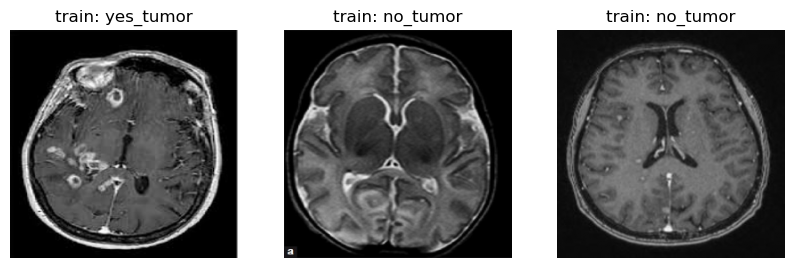

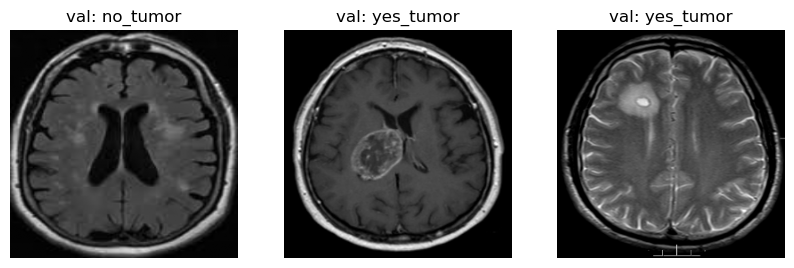

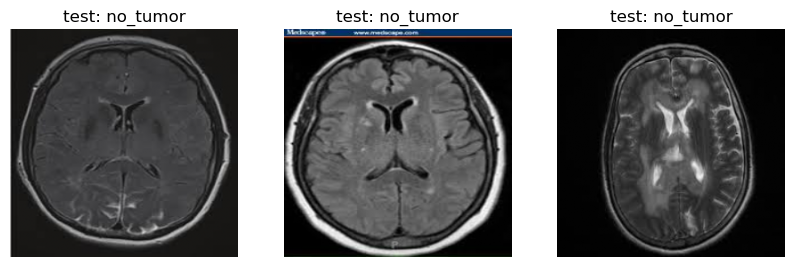

In [57]:
# Load and verify saved data
def verify_subset(subset):
    images = np.load(PROCESSED_PATH/subset/"images.npy")
    labels = np.load(PROCESSED_PATH/subset/"labels.npy")
    
    plt.figure(figsize=(10,4))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(images[i])
        plt.title(f"{subset}: {CLASSES[labels[i]]}")
        plt.axis('off')
    plt.show()

verify_subset("train")
verify_subset("val")
verify_subset("test")

In [67]:
save_processed_data(X_train, y_train, "train")
save_processed_data(X_val, y_val, "val")
save_processed_data(X_test, y_test, "test")

Saved 136 train samples
Saved 29 val samples
Saved 30 test samples


In [69]:
print("Current working directory:", os.getcwd())
print("Absolute path to data:", Path('data/processed').resolve())

Current working directory: F:\Brain_Tumour\Brain_Tumor_Classification\notebooks
Absolute path to data: F:\Brain_Tumour\Brain_Tumor_Classification\notebooks\data\processed


In [75]:
from pathlib import Path
import numpy as np

# Check if the new paths are correct
for subset in ['train', 'val', 'test']:
    path = Path(f'../data/processed/{subset}/images.npy')
    print(f"{path}: {'EXISTS ✅' if path.exists() else 'MISSING ❌'}")

# Now load and check the files using correct paths
def verify_data_integrity():
    for subset in ['train', 'val', 'test']:
        try:
            images = np.load(f'../data/processed/{subset}/images.npy')
            labels = np.load(f'../data/processed/{subset}/labels.npy')
            print(f"✅ {subset}: {len(images)} images, {len(labels)} labels")
        except Exception as e:
            print(f"❌ {subset} failed: {str(e)}")

verify_data_integrity()


..\data\processed\train\images.npy: EXISTS ✅
..\data\processed\val\images.npy: EXISTS ✅
..\data\processed\test\images.npy: EXISTS ✅
✅ train: 136 images, 136 labels
✅ val: 29 images, 29 labels
✅ test: 30 images, 30 labels


In [ ]:
## Preprocessing Summary

### Issue Identified:
- Data files (`images.npy`, `labels.npy`) were reported as missing during verification
- Path resolution was incorrect due to notebook/data directory structure mismatch

### Solution Implemented:
1. **Path Correction**:
   - Updated relative paths from `data/processed/...` to `../data/processed/...`
   - This properly navigates from the notebooks directory to the project root

2. **Verification**:
   - Confirmed all files now exist in correct locations:
     - ✅ `../data/processed/train/`
     - ✅ `../data/processed/val/` 
     - ✅ `../data/processed/test/`
   - Validated data integrity with correct sample counts:
     - Train: 136 samples
     - Val: 29 samples
     - Test: 30 samples

### Key Learnings:
- Always verify absolute paths when working with file I/O
- Relative paths should account for script execution context
- Directory structure documentation helps prevent path issues